# Simple synthetic data test

This is test of the gravity inversion code on synthetic data generated from a simple model. 

We'll use this example to show that the method works and is efficient. We'll also use it to compare the formulations using the Steepest Descent and Newton's method. The results show how each formulation performs on regularized problem using smoothness constraints.

## Smoothness regularization in Steepest Descent

Test that the inversion by Steepest Descent works with smoothness regularization. Adding smoothness, the step becomes

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - [\nabla \Theta(\mathbf{p}^k) + \mu \nabla \Phi_{smooth}(\mathbf{p}^k)]
$$

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
- \mu 2 \mathbf{R}^T \mathbf{R} \mathbf{p}^k
$$

This is the approach adopted by Santos et al. (2015) (though they fail to mention it in the article).

## Using Gauss-Newton to impose smoothness


$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[ \mathbf{A}^T \mathbf{A} + \mu \mathbf{R}^T \mathbf{R} \right]^{-1} 
\left[ \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)] - \mu \mathbf{R}^T \mathbf{R}\mathbf{p}^k \right]
$$


Is there a difference between both methods? We've seen from the `moho-inversion-class.ipynb` notebook that the computation time is practically the same. If there is a difference, which is better?

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division
import multiprocessing
import cPickle as pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn  # Makes the default style of the plots nicer

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [3]:
from fatiando.inversion import Smoothness2D
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando

In [4]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [5]:
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical, make_mesh, cross_validation

Get the number of cores in this computer to run the some things in parallel.

In [6]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 4


## Create a model and generate synthetic data

Define the computation grid.

In [7]:
shape = (51, 51)
# Make a regular grid inside an area
area = (10, 70, -50, 50)
grid_height = 50e3
lat, lon, h = gridder.regular(area, shape, z=grid_height)

Next, we'll define the reference level (height in meters) and make a synthetic Moho relief that simulates the transition from continental to oceanic crust.

In [8]:
reference = -30e3

In [9]:
relief = (
    -25e3 + 15e3*sp.special.erf((lon - 10)/20) # The general flow from continent to ocean
    - 15e3*utils.gaussian2d(lat, lon, 10, 15, x0=25, y0=-30)
    + 15e3*utils.gaussian2d(lat, lon, 15, 20, x0=53, y0=-25)
    - 10e3*utils.gaussian2d(lat, lon, 3, 3, x0=50, y0=30)
    - 10e3*utils.gaussian2d(lat, lon, 10, 10, x0=30, y0=25)**2
    + 5e3*utils.gaussian2d(lat, lon, 40, 3, x0=40, y0=40, angle=15)
    )

Lets make a plot of our Moho model.

In [10]:
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='c')

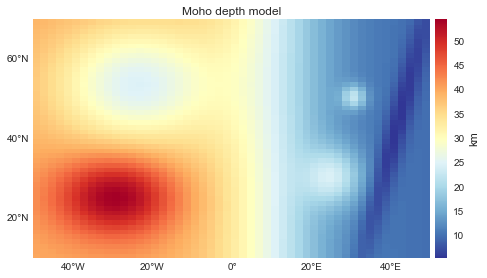

In [11]:
x, y = bm(lon.reshape(shape), lat.reshape(shape))

data = -0.001*relief.reshape(shape)

plt.figure(figsize=(7, 3.5))
plt.title("Moho depth model")
bm.pcolormesh(x, y, data, cmap='RdYlBu_r')
plt.colorbar(pad=0.01).set_label('km')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout(pad=0)

Now, we need to assign a density contrast to our model.  We'll assume a homogeneous density constrat along the Moho. The density contrast will be negative if the Moho is below the reference and positive if it is above.

In [12]:
density_contrast = 600
print("Using density contrast of {} kg.m^-3".format(density_contrast))
density = density_contrast*np.ones_like(relief)
# The density contrast is negative if the relief is below the reference
density[relief < reference] *= -1

Using density contrast of 600 kg.m^-3


Make a `TesseroidRelief` mesh using the `make_mesh` utility function and assign the density contrast values to it.

In [13]:
model = make_mesh(area, shape, relief, reference)
model.addprop('density', density)

Forward model the synthetic data on a regular grid at a constant height. Contaminate the data with pseudo-random Gaussian noise to make it more realistic.

In [14]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)
gz = utils.contaminate(gz, 5, seed=0)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


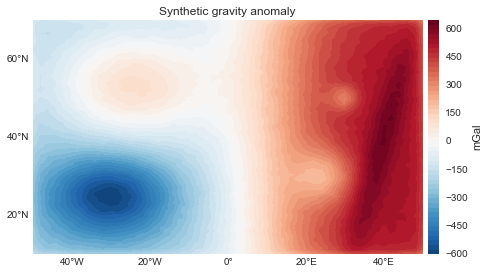

In [15]:
x, y = bm(lon, lat)

plt.figure(figsize=(7, 3.5))
plt.title('Synthetic gravity anomaly')
ranges = np.abs([gz.max(), gz.min()]).max()
bm.contourf(lon, lat, gz, 50, cmap='RdBu_r', tri=True, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01).set_label('mGal')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout(pad=0)

## Define plotting functions

These functions plot the results of the inversion for us. We'll define them all here and use them below for each inversion that we run.

In [16]:
def plot_result_maps(solver):
    # Make plots of the data fit, the estimated Moho depth, and the difference 
    # with the true values.
    predicted = solver[0].predicted()
    residuals = solver[0].residuals()
    moho = solver.estimate_
    
    ranges = np.abs([gz.max(), gz.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, gz, shape, 25, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels, basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.6, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True)
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 3.5))
    plt.title("Estimated Moho depth using {}".format(solver.stats_['method']))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='RdYlBu_r')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)
    
    
    diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
    ranges = np.abs([diff.max(), diff.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title("Difference between true and estimated")  
    bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    plt.tight_layout(pad=0)

In [17]:
def plot_cv(best, regul_params, scores, solver, log=True):    
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation for {}'.format(solver.stats_['method']))
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)

In [18]:
def plot_convergence(solver):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence of {}'.format(solver.stats_['method']))
    plt.plot(range(solver.stats_['iterations'] + 1), solver.stats_['objective'])
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.ylabel('Goal function')
    plt.tight_layout(pad=0)

## Inversion setup

We need to make a mesh for the inversion. We'll use a mesh that is equal to the original model. This will make it easier to compare the inversion results with the true model.

In [19]:
# Make a mesh
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)

We also need to define an initial estimate because this is a non-linear inversion. Next, we create the data-misfit and regularization objects that we'll use in the inversions below.

In [20]:
initial = np.ones(mesh.size)*(-60e3)
misfit = MohoGravityInvSpherical(lat, lon, h, gz, mesh)
regul = Smoothness2D(mesh.shape)

## Cross-validation

We'll use cross-validation to determine the optimal value of the regularization parameter.
The way this works is:

1. Create a separate dataset that will be used to check our solutions (the test dataset $\mathbf{d}_{test}$)
2. Run the inversion on the observed data for each value of the regularization parameter
3. For each solution, calculate the predicted data for the **test dataset** ($\mathbf{d}'_{test}$ and the corresponding Mean Square Error (MSE) error.
4. Choose the solution with the smallest MSE value for the test dataset.

The MSE is

$$
MSE = \dfrac{[\mathbf{d}_{test} - \mathbf{d}'_{test}]^T[\mathbf{d}_{test} - \mathbf{d}'_{test}]}{N_{test}}
$$

First, create the test data. I'll use a regular grid as well but at a lower height. This could be obtained from the same spherical harmonic model.

In [21]:
test_shape = [int(s*1.2) for s in shape]
print("Number of grid points in the test data: {}".format(str(test_shape)))
test_lat, test_lon, test_h = gridder.regular(area, test_shape, z=10e3)
test_data = tesseroid.gz(test_lon, test_lat, test_h, model, njobs=ncpu)
test_data = utils.contaminate(test_data, 5, seed=10)  # Use a different seed to get independent errors
test_set = [test_lat, test_lon, test_h, test_data]

Number of grid points in the test data: [61, 61]


## Solution using Steepest Descent

Let's try using the steepest descent method first. We'll make a Python dictionary (`dict`) to store the solver configuration for this method. `tol` is the tolerance level that controls the stopping criterion. `maxit` is the maximum allowed number of iterations. `linesearch=False` tells the algorithm not to perform a line search for the step size. 

In [22]:
steep_config = dict(method='steepest', initial=initial, tol=0.1, maxit=10, linesearch=False)

Next, we define a list of the possible regularization parameters that will be considered during cross-validation. `logspace` generates a list of values evenly spaced in a logarithmic scale.

In [23]:
regul_params = np.logspace(-6, -1, 12)
regul_params

array([  1.00000000e-06,   2.84803587e-06,   8.11130831e-06,
         2.31012970e-05,   6.57933225e-05,   1.87381742e-04,
         5.33669923e-04,   1.51991108e-03,   4.32876128e-03,
         1.23284674e-02,   3.51119173e-02,   1.00000000e-01])

Run the cross-validation. This runs the inversion for each value in `regul_params`, calculates the MSE of the solutions for the test dataset, and returns the result that best fits the test dataset. All of this is done in parallel using all available cores. 

In [24]:
%time results_steep = cross_validation(misfit, regul, regul_params, steep_config, test_set, njobs=ncpu)

CPU times: user 285 ms, sys: 61.4 ms, total: 347 ms
Wall time: 7min 25s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not

This takes some time to run. We can save the results to a [Python pickle file](https://docs.python.org/2/library/pickle.html) and load it later to avoid re-calculating every time.

In [25]:
with open('synthetic-steepest-vs-newton.steepest.pickle', 'w') as f:
    pickle.dump(results_steep, f)

Uncomment and use the cell below to load the saved results. This will save time when making and tweaking plots (so we don't need to do the long computation again).

In [26]:
#with open('synthetic-steepest-vs-newton.steepest.pickle') as f:
#    results_steep = pickle.load(f)

Unpack the results and plot the cross-validation data. The graph will show the MSE per regularization parameter. The chosen solution is the one that minimizes the MSE.

In [27]:
best, solution_steep, scores, solvers = results_steep

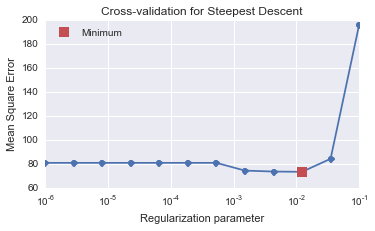

In [28]:
plot_cv(best, regul_params, scores, solution_steep, log=False)

Plot the convergence of the best solution (goal function value per iteration) to see if the solution converges. Note that the y-axis is in a logarithmic scale.

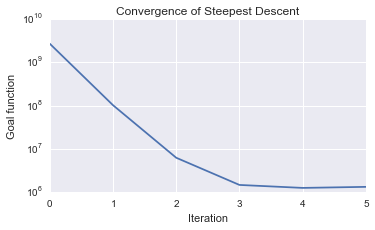

In [29]:
plot_convergence(solution_steep)

Now we can plot the results for the best solution found using Steepest Descent. The maps below show the data fit (observed vs predicted), a histogram of the inversion residuals, the estimated Moho depth, and the difference between the estimated and true Moho depths.

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


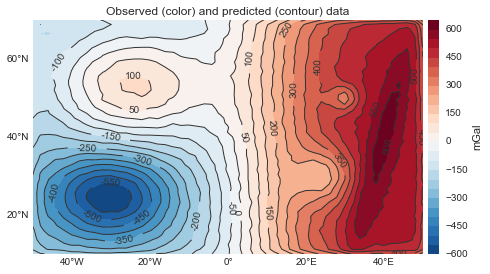

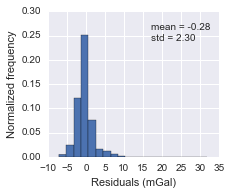

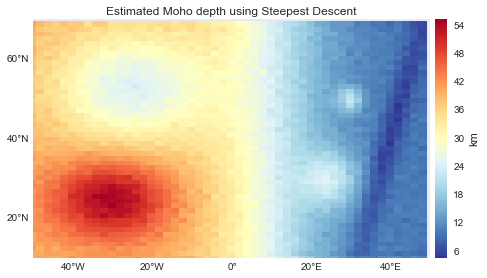

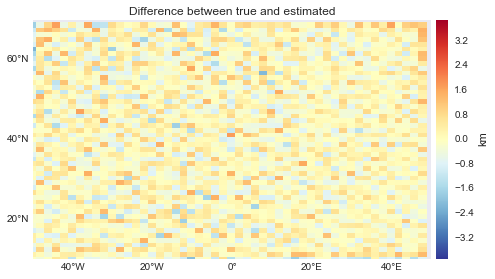

In [30]:
plot_result_maps(solution_steep)

**Notice that the solution is still not smooth.** Even when using smoothness regularization, the solution using Steepest Descent does not provide a fully smooth Moho. The random errors in the data were still propagated to the solution.

The solution also seems to be over-fitting the data, even though we're using the optimal value determined by cross-validation. The predicted data fit even the high-frequency random noise in the data.

It seems that using only the gradient of the smoothness regularization with Steepest Descent is not enough to fully smooth the solution. However, this is the approach taken by [Santos et al. (2015)](http://dx.doi.org/10.1190%2Fgeo2014-0513.1) and they present smooth solutions. Maybe that is because they start out with a regularized solution as an initial estimate that is very close to the final solution already.

## Solution using Newton's method

Lets see if Newton's method yields a better solution. 

The configuration for the method is very similar to Steepest Descent but has no `linesearch` parameter.

In [31]:
newton_config = dict(method='newton', initial=initial, tol=0.1, maxit=10)

In [32]:
regul_params = np.logspace(-6, -1, 12)
regul_params

array([  1.00000000e-06,   2.84803587e-06,   8.11130831e-06,
         2.31012970e-05,   6.57933225e-05,   1.87381742e-04,
         5.33669923e-04,   1.51991108e-03,   4.32876128e-03,
         1.23284674e-02,   3.51119173e-02,   1.00000000e-01])

In [33]:
%time results_newton = cross_validation(misfit, regul, regul_params, newton_config, test_set, njobs=ncpu)

CPU times: user 313 ms, sys: 86.3 ms, total: 399 ms
Wall time: 8min 25s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not

Also save these results to a pickle file for later use.

In [34]:
with open('synthetic-steepest-vs-newton.newton.pickle', 'w') as f:
    pickle.dump(results_newton, f)

Uncomment and use the cell below to load the saved results. This will save time when making and tweaking plots (so we don't need to do the long computation again).

In [35]:
#with open('synthetic-steepest-vs-newton.newton.pickle') as f:
#    results_newton = pickle.load(f)

Unpack the results and make the plots.

In [36]:
best, solution_newton, scores, solvers = results_newton

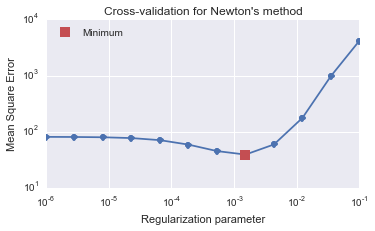

In [37]:
plot_cv(best, regul_params, scores, solution_newton)

Notice that the cross-validation curve for Newton's method has a better defined minimum than for Steepest Descent.

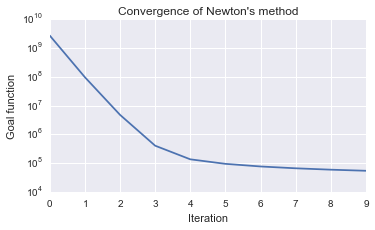

In [38]:
plot_convergence(solution_newton)

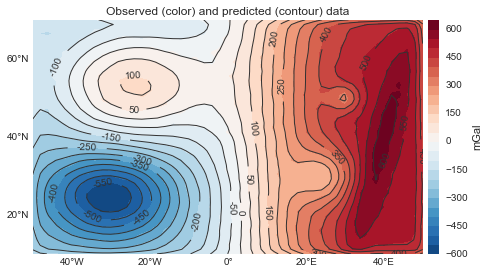

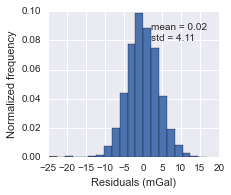

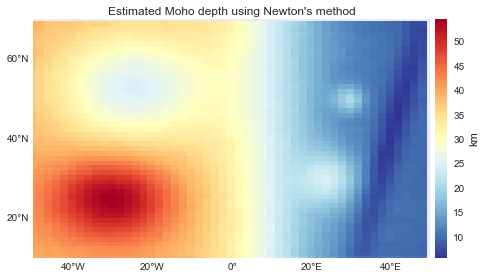

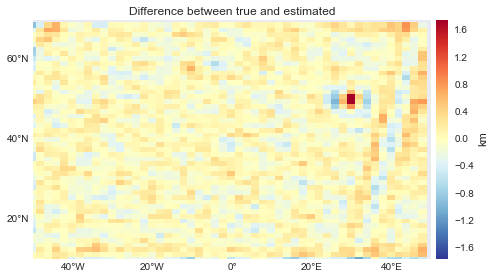

In [39]:
plot_result_maps(solution_newton)

The solution using Newton's method is smoother than the solution for Steepest Descent. We can also see that this solution does not over-fit the data. The predicted data (black contour lines) don't present the random noise seen in the observed data. The standard deviation of the residuals is also closer to the 5 mGal standard deviation used to generate the data errors.